In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import linalg
from scipy.sparse import csgraph, csr_matrix

import networkx as nx

from IPython.display import display
import sympy
sympy.init_printing()

def pprint(m):
    display(sympy.Matrix(m))

Let's represent a graph with an adiacency matrix.  This is a **directed** graph, because we select the start node and the end node.

In [3]:
adj_d = [
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
]
adj_d = csr_matrix(adj_d)
print(adj_d)

  (0, 1)	1
  (1, 2)	1
  (2, 3)	1
  (3, 0)	1


The same **undirected** graph is represented by

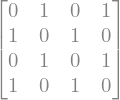

In [4]:
adj_u = adj_d + adj_d.T
pprint(adj_u.toarray())

### Graph Laplacian

$$ L = D - A $$

- D is the diagonal matrix containing the degree of each node
- A is the $n \times n$ adjacency matrix, indicating if pair of vertices are adjacent or not.

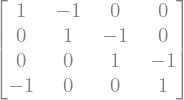

In [5]:
# directed
L_d = csgraph.laplacian(adj_d)
pprint(L_d.toarray())

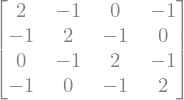

In [6]:
# undirected
L = csgraph.laplacian(adj_u)
L = L.toarray()
pprint(L)

In [7]:
nx_graph_d = nx.DiGraph(adj_d)
nx_graph = nx.Graph(adj_d)

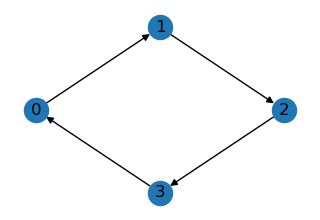

In [8]:
positions = {0: [0, 1], 1: [1, 2], 2: [2, 1], 3: [1, 0]}
plt.rcParams["figure.figsize"] = [3, 2]
nx.draw(nx_graph_d, with_labels=True, pos=positions)

## Effective Resistance

Let's assume that each edge had resistance $R=1$.  

The effective resistance between nodes $a$ and $b$ is computed using the **rules of compositions in series and parallel.**

- $R_{0,0} = 0$.

- $R_{0,1}$.  $$ R_{0,1} = \frac{1}{1+\frac{1}{3}} = \frac{3}{4} = 0.75 $$ 

- $R_{0,2}$.  $$ R_{0,2} = \frac{1}{\frac{1}{2}+\frac{1}{2}} = 1 $$

- $R_{0,3} = R_{0,1}$, by symmetry.  


### ER using networkx

In [9]:
def compute_ER_by_nx(G):
    """Based on np.linalg.pinv(L, hermitian=True)"""
    N = G.number_of_nodes()
    ER = np.zeros((N, N))
    for i in range(N):
        for j in range(i + 1, N):
            ER[i, j] = nx.resistance_distance(G, i, j)
    ER = ER + ER.T
    return ER

<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


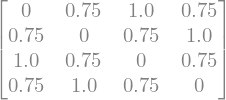

In [10]:
ER = compute_ER_by_nx(nx_graph)
pprint(ER)

### Effective resistance general formula

The effective resistance $R_{a,b}$ between nodes $a$ and $b$ can be computed using the graph Laplacian.    

If we associate each node $i$ with an element $e_i$ of the standard basis of the Euclidean vector space $\mathbb{R}^n$, we can define the effective resistance between any nodes $i$, $j$ as follows:

$$ R_{ij} = (e_i - e_j)^T \, L^{\dagger} \, (e_i - e_j) $$

where $L^{\dagger}$ is the pseudo-inverse of the graph Laplacian.

The effective resistance between $a$ and $b$ is:

$$ 
\begin{aligned}
R_{ab} &= (e_a - e_b)^T \, L^{\dagger} \, (e_a - e_b) \\
       &= L^{\dagger}[a,a] + L^{\dagger}[b,b] - 2 L^{\dagger}[a,b] 
\end{aligned}       
$$

#### Rank and determinant

In [11]:
rank = np.linalg.matrix_rank(L)
determinant = np.linalg.det(L)
print("Matrix dimensions: ", L.shape)
print("Rank = ", rank)
print("Determinant = ", determinant.round(10))

Matrix dimensions:  (4, 4)
Rank =  3
Determinant =  0.0


### Pinv
Let's do it by computing the Moore-Penrose pseudo-inverse with `numpy.linalg.pinv`.    
(Calculate a generalized inverse of a matrix using its **singular-value decomposition**)

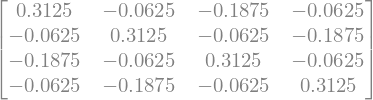

In [12]:
L_pinv = np.linalg.pinv(L, hermitian=True)
pprint(L_pinv.round(5))

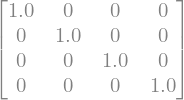

In [13]:
e = np.eye(4)
pprint(e)

The effective resistance between $0$ and $1$ is:

In [14]:
R_01 = (e[0] - e[1]) @ L_pinv @ (e[0] - e[1])
print("R_01 = ", R_01)

R_01 =  0.7499999999999998


Or alternatively:

In [15]:
R_01 = L_pinv[0, 0] + L_pinv[1, 1] - 2 * L_pinv[0, 1]
print("R_01 = ", R_01)

R_01 =  0.7499999999999998


### Regularization approach

We add a small perturbation on the diagonal, and then invert L.

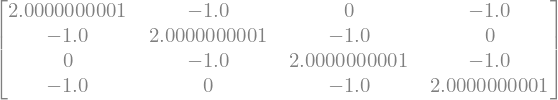

In [16]:
L_regul = L + 1e-10 * np.eye(4)
pprint(L_regul)

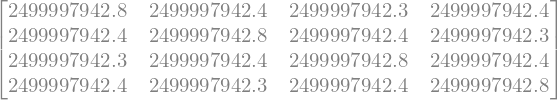

In [17]:
inv_L_regul = np.linalg.inv(L_regul)
pprint(inv_L_regul.round(1))

Inverting is bad.  Better to **solve a linear system**:

$$ L \, x = \mathbb{1}  \Longrightarrow x = L^{-1} $$

Here the performance is the same, but with big sparse L it is better to solve the system.

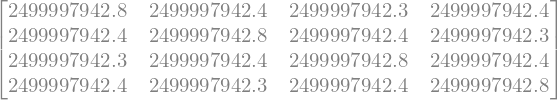

In [18]:
sys_inv_L = linalg.solve(L_regul, e)
pprint(sys_inv_L.round(1))

In [19]:
v = e[0] - e[1]

R_01_regul = v.T @ inv_L_regul @ v
print("The ER from 0 to 1 using regularization is: ", R_01_regul.round(4))

The ER from 0 to 1 using regularization is:  0.75


### Solving a linear system

We define the vector $v = e_a - e_b$.

If $L$ is invertible, we can solve a linear system to compute the ER only between the nodes we are interested in.

$$ 
\begin{aligned}
R_{ab} &= (e_a - e_b)^T \, L^{\dagger} \, (e_a - e_b) \\
       &= v^T \, L^{\dagger} \, v   \\
       &= v^T \, x  \quad \quad \text{with} \quad x = L^{\dagger} \, v
\end{aligned}       
$$

Therefore we can solve the linear system 

$$ L x = v $$

and then 

$$ R_{ab} \; = \; v^T x \; = \; x[a] - x[b] $$

In [20]:
x = linalg.solve(L_regul, v)

In [21]:
ER_01_sys = x[0] - x[1]
print("Effective resistance 0-1 by linear system: ", ER_01_sys.round(2))

Effective resistance 0-1 by linear system:  0.75


### Calculation of PINV using eigenvalues and eigenvectors

In [22]:
eig_val, eig_vec = linalg.eig(L)
eig_val = np.real(eig_val)
eig_vec = np.real(eig_vec)

Eigenvectors: 


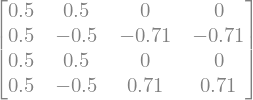

Eigenvalues: 


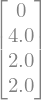

In [23]:
print("Eigenvectors: ")
pprint(eig_vec.round(2))  # each column is an eigenvector
print("Eigenvalues: ")
pprint(eig_val.round(2))

If $\lambda$ is an eigenvalue and $u$ an eigenvector, we have:

$$ L u = \lambda u $$

If we call $U$ the matrix with an eigenvector on each column, and $\Lambda$ the diagonal matrix of the eigenvalues, we have:

$$ U^T \, L \, U \, = \, \Lambda $$

$L$ is symmetric (Hermitian) and the eigenvalues are real and non-negative. **The smallest eigenvalue is 0**.     
The eigenvector corresponding to the zero eigenvalue is:

$$ \phi \propto \sum_{i=1}^N e_i $$

The matrix U is unitary $U\,U^{-1} = U\, U^{T} = \mathbb{1}$ or $U^{T} = U^{-1}$.

We can take the inverse on both sides:

$$ \biggl( U^T \, L \, U \biggr)^{-1} \, = \, \Lambda^{-1} $$

$$ U^{-1} \, L^{-1} \, U \, = \, \Lambda^{-1} $$

$$ L^{-1} \, = \, U\, \Lambda^{-1} \, U^{T} $$

If the eigenvalue is zero, we define its inverse as zero.

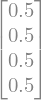

In [24]:
phi = np.sum(e, axis=1)  # sum of the columns of e
phi = phi / (np.sqrt(phi @ phi))  # normalization of phi
pprint(phi)

In [25]:
ind = 1
print("L u = ", np.round(L @ eig_vec.T[ind], 4))
print("lam u = ", np.round(eig_val[ind] * eig_vec.T[ind], 4))

L u =  [ 2. -2.  2. -2.]
lam u =  [ 2. -2.  2. -2.]


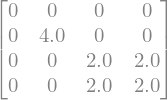

In [26]:
eig_val_mat = eig_vec.T @ L @ eig_vec
pprint(eig_val_mat.round(2))

In [27]:
diag_inv = np.where(eig_val > 0, 1 / eig_val, 0)
diag_inv

array([0.  , 0.25, 0.5 , 0.5 ])

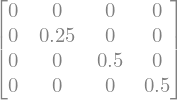

In [28]:
D_inv = np.diag(diag_inv)
pprint(D_inv)

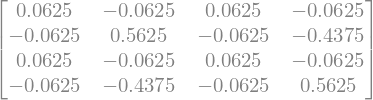

In [29]:
L_inv_eig = eig_vec @ D_inv @ eig_vec.T
pprint(L_inv_eig.round(4))

## Let's create another graph

In [30]:
gr = {"start_node": [0, 1, 2, 3, 4, 3, 2], "end_node": [1, 2, 3, 4, 1, 5, 6]}
positions = {0: [0, 0], 1: [1, 0], 2: [2, 0], 3: [2, 1], 4: [1, 1], 5: [3, 1], 6: [3, 0]}
nx_graph = nx.Graph()

In [31]:
for i in zip(gr["start_node"], gr["end_node"]):
    nx_graph.add_edge(*i)

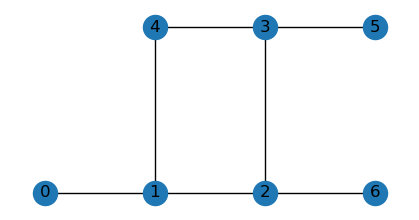

In [32]:
plt.rcParams["figure.figsize"] = [4, 2]
nx.draw(nx_graph, with_labels=True, pos=positions)

/var/folders/_p/fvph973x59g67y9qng1ltjgr0000gn/T/ipykernel_11220/4141047638.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  ADJ = nx.adjacency_matrix(nx_graph).toarray()


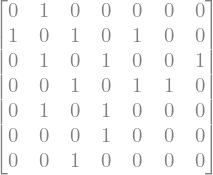

In [33]:
ADJ = nx.adjacency_matrix(nx_graph).toarray()
pprint(ADJ)

<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


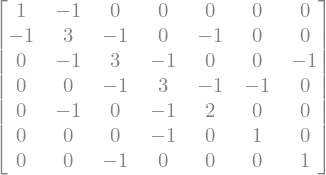

In [34]:
L = nx.laplacian_matrix(nx_graph.to_undirected()).toarray()
pprint(L)

### The Incidence matrix

Let us introduce the $n \times m$ **oriented** incidence matrix $B$ (with $n$ nodes and $m$ edges) defined as $B_{i,k} = 1$ and $B_{j,k} = −1$, with $k$ representing the index of the oriented edge connecting nodes $i$ to node $j$.

/var/folders/_p/fvph973x59g67y9qng1ltjgr0000gn/T/ipykernel_11220/3547226729.py:1: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  B = -nx.incidence_matrix(nx_graph, oriented=True).toarray().astype(int)


The incidence matrix has shape  (7, 7)


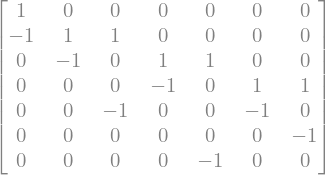

In [35]:
B = -nx.incidence_matrix(nx_graph, oriented=True).toarray().astype(int)
print("The incidence matrix has shape ", B.shape)
pprint(B)

In [36]:
print("Nodes ", nx_graph.nodes)
print("Edges ", nx_graph.edges)

Nodes  [0, 1, 2, 3, 4, 5, 6]
Edges  [(0, 1), (1, 2), (1, 4), (2, 3), (2, 6), (3, 4), (3, 5)]


The Laplacian can be compute also as 

$$ L = B B^T $$

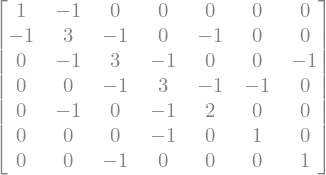

In [37]:
pprint(B @ B.T)

### Computation of pressure and flow inside the the graph.


Pressure $p$: 

$$ L \, p = Q_b $$

with $Q_b$ the flow on the boundary nodes.   
The solution of the above equation is up to a constant. It means that for any $K\in \mathbb{R}$, $p+K$ is a solution.

Flow $Q$ on edges:

$$ Q = B^T p $$

In [38]:
boundary_flows = np.zeros(nx_graph.number_of_nodes())
boundary_flows[0] = 1
boundary_flows[5] = -0.5
boundary_flows[6] = -0.5
boundary_nodes = [elem[0] for elem in nx_graph.degree if elem[1] == 1]
print("Boundary nodes have degree 1: ", boundary_nodes)
print("Flow on the boundary nodes: ", boundary_flows)

Boundary nodes have degree 1:  [0, 5, 6]
Flow on the boundary nodes:  [ 1.   0.   0.   0.   0.  -0.5 -0.5]


In [39]:
print("Total flow on boundaries: ", boundary_flows[boundary_nodes].sum())

Total flow on boundaries:  0.0


#### Pressure on each node

In [40]:
L_reg = L + 1e-14 * np.eye(7)
pressure = linalg.solve(L_reg, boundary_flows)
print("Pressure = ", pressure)

Pressure =  [ 1.44336077  0.44336077 -0.18163923 -0.30663923  0.06836077 -0.80663923
 -0.68163923]


#### Flow on edges

In [41]:
Q = B.T @ (pressure)
print("Flow on edges: ", Q)
print("Edges:    ", nx_graph.edges)

Flow on edges:  [ 1.     0.625  0.375  0.125  0.5   -0.375  0.5  ]
Edges:     [(0, 1), (1, 2), (1, 4), (2, 3), (2, 6), (3, 4), (3, 5)]


#### Flow conservation

Using $ Q = B^T p $ we can apply $B$ on the left:

$$ B Q = B B^T p = L p = Q_b $$

We can check the flow conservation on each node by multiplting B and Q. The resulting matrix is a $(n \times m) \times (m \times 1) = (n \times 1)$ matrix, that associate each node with the total flow on that node.     
We can see that the flow on the internal nodes is zero!

In [42]:
conserv = B @ Q
print("Flow on each node: ", conserv.round(2))

Flow on each node:  [ 1.  -0.   0.   0.  -0.  -0.5 -0.5]


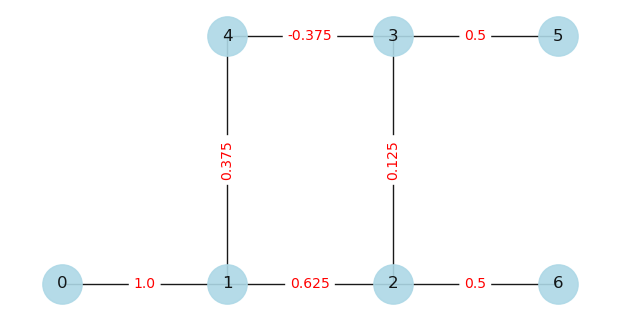

In [43]:
labels = dict(zip(nx_graph.edges, Q.round(3)))

plt.rcParams["figure.figsize"] = [6, 3]
nx.draw(nx_graph, with_labels=True, pos=positions, node_size=800, node_color="lightblue", alpha=0.9)

nx.draw_networkx_edge_labels(nx_graph, pos=positions, edge_labels=labels, font_color="red")
plt.show()

## References

[1] Klein, D.J. Randic, M.  "Resistance distance" Journal of Mathematical Chemistry. (1993) 81-95